In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  
from sklearn.decomposition import PCA
import umap
import umap.plot
import plotly.graph_objs as go 
import plotly.io as pio 
pio.renderers.default ='iframe'

from collections import defaultdict

import math,os,sys
import warnings 
warnings.filterwarnings('ignore')

In [2]:
from mnist_dataset import MNISTDataset 
#load dataset 
data = pd.read_csv('../data/train.csv')
data = data[:100]
#temporarly trying to overfit with less data
val_count =2

#common transformation
default_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])

#split the train to val and train
dataset = MNISTDataset(data.iloc[:-val_count], default_transform)
val_dataset = MNISTDataset(data.iloc[-val_count:], default_transform)


100%|█████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 413.56it/s]


In [3]:
#setup Dataloaders with pytorch dataloaders
trainloader = DataLoader(
    dataset,
    batch_size = 32,
    shuffle =True,
    #pin_memory = True, # for faster data transfer speed btn CPU and GPU, but will consume more system memory
    num_workers = 2,
    #prefetch_factor = 100,#to specify how many batches should be prefetched(loaded into memory[increased memory usage tho]) asynchronously in advance.

) 

# visualizing Datapoints

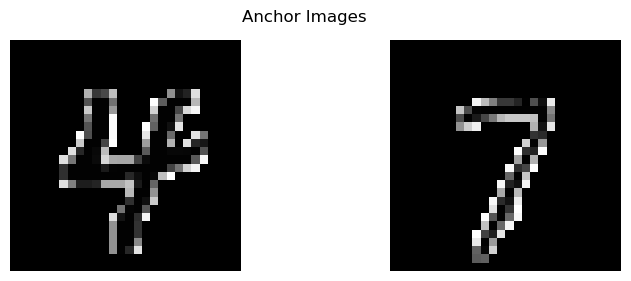

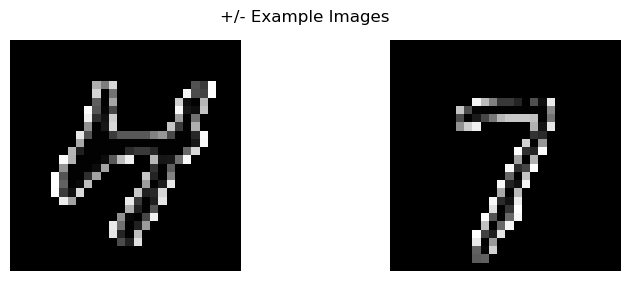

In [4]:
def show_images(images, title =''):
    num_images = len(images)
    fig,axes = plt.subplots(1, num_images,figsize=(9,3))
    for i in range(num_images):
        img = np.squeeze(images[i])
        axes[i].imshow(img,cmap='gray')
        axes[i].axis('off')
    fig.suptitle(title)
    plt.show()
    
for batch_idx, (anchor_images, contrastive_images, distances, labels) in enumerate(trainloader):
    #converting tensors to numpy, numpy is easy to muniplate and display with matplotlib
    anchor_images = anchor_images.numpy()
    contrastive_images = contrastive_images.numpy()
    labels = labels.numpy()

    #display some imgages from batch
    show_images(anchor_images[:4], title = 'Anchor Images')
    show_images(contrastive_images[:4], title = '+/- Example Images')
    #break after displaying from one batch for demostration 
    break

# lets build Neural Network
-  Define a neural network architecture with two convolution layers and two fully connected layers
- Input to the network is an MNIST image and Output is a 64 dimensional representation. 


In [5]:
from Network import Network, ContrastiveLoss

In [6]:
net = Network()

device= "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device= "mps"

#device= "cpu" #overide device for overfitting a very small data batch
net = net.to(device)

device

'mps'

### weight initialization 

In [7]:
# Custom initialization function
# def init_weights(m):
#     if isinstance(m, nn.Conv2d):
#         nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#         if m.bias is not None:
#             nn.init.zeros_(m.bias)
#     elif isinstance(m, nn.Linear):
#         nn.init.xavier_uniform_(m.weight)
#         nn.init.zeros_(m.bias)

def init_weights(model, gain=1.0):
    def init_module(m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='gelu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='gelu')
            nn.init.zeros_(m.bias)
    
    # Apply initialization to each module in the model
    model.apply(init_module)

In [8]:
def init_weights_for_gelu(m):
    if isinstance(m, nn.Conv2d):
        # Initialize Conv2d weights with a scaled normal distribution
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        # Initialize Linear weights with a scaled normal distribution
        in_features = m.weight.size(1)
        std = 1. / math.sqrt(in_features)
        m.weight.data.normal_(0, std)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [9]:
epoch_count=10
max_lr = 6e-4
min_lr = max_lr *10 
max_steps = epoch_count
warm_up_steps = max_steps * 0.2

def get_lr(iter):
    #linear warm up for warm up steps
    if iter < warm_up_steps:
        return max_lr * (iter+1) / warm_up_steps
    #if iter > lr_decay_iters, return min learning rate
    if iter > max_steps:
        return min_lr
    #in between ,use cosine decay down to min learning rate
    decay_ratio = (iter - warm_up_steps) / (max_steps - warm_up_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) #coffe starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)

In [10]:
# lre = torch.linspace(-3,0,100)
# lrs = 10**lre

In [22]:
optimizer = torch.optim.AdamW(net.parameters(), lr = 0.0003)
#optimizer = torch.optim.AdamW(net.parameters())
loss_function = ContrastiveLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.3)


In [12]:
import os
checkpoint_dir ='checkpoints/'

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [13]:
# def save_checkpoint(net, epoch, checkpoint_dir='checkpoints'):
#     os.makedirs(checkpoint_dir, exist_ok=True)
#     checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt')
#     torch.save(net.state_dict(), checkpoint_path)

In [14]:
# lre = torch.linspace(-3,0,1000)
# lrs = 10**lre
#print(lrs)
    

In [28]:
activations_list = []
gradients = []
activation_metrics = defaultdict(lambda: {'tensors': []})
custom_gain = math.sqrt(2) # Example: Adjust this value as needed
#custom_gain = nn.init.calculate_gain('relu')  # Calculate gain for ReLU


def Train_model(epoch_count=10):
    net = Network()
    net.apply(init_weights_for_gelu)
    #init_weights(net, gain=custom_gain)
    net = net.to(device)
    lrs = []
    losses = []
    activations = []
    #--------
    
    def get_activation(name):
        def hook(model, input, output):
            activations.append((name, output.detach()))
        return hook

    # Hook function to capture activations
    def capture_activations(name):
        def hook(module, input, output):
            activation_metrics[name]['tensors'].append(output.detach())
        return hook
    
    # Register hooks for ReLU layers
    for name, layer in net.named_modules():
        if isinstance(layer, nn.ReLU):
            layer.register_forward_hook(capture_activations(name))
        #-----------
   

    def capture_gradient(name):
        def hook(module, grad_input, grad_output):
            gradients.append((name, grad_output[0].detach()))
        return hook
        
    # Register hooks for capturing gradients in ReLU layers
    for name, layer in net.named_modules():
        if isinstance(layer, nn.ReLU):
            layer.register_backward_hook(capture_gradient(name))

    # Register hooks for ReLU layers
    for layer in net.modules():
        if isinstance(layer, nn.ReLU):
            layer.register_forward_hook(get_activation(layer.__class__.__name__))
    #------------
    for epoch in range(epoch_count):
        epoch_loss = 0
        batches = 0
        print('epoch-',epoch) 
        for param_group in optimizer.param_groups:
            lrs.append(param_group['lr'])
        
        print('learning rate',lrs[-1])

        for anchor, contrastive, distance, label in tqdm(trainloader):
            
            # Ensure data is in the correct shape
            assert anchor.shape[1] == 1, f"Expected anchor channels to be 1, but got {anchor.shape[1]}"
            assert contrastive.shape[1] == 1, f"Expected contrastive channels to be 1, but got {contrastive.shape[1]}"

            batches +=1
            optimizer.zero_grad()
            anchor_out = anchor.to(device, dtype=torch.float32)
            contrastive_out = contrastive.to(device, dtype=torch.float32)
            distance = distance.to(torch.float32).to(device)

            anchor_out = net(anchor_out)
            contrastive_out = net(contrastive_out)
            
            loss = loss_function(anchor_out, contrastive_out, distance)
            epoch_loss += loss
            loss.backward()
            norm = torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            optimizer.step()
        
        print(activations)
        activations_list.append(activations)            
        losses.append(epoch_loss.cpu().detach().numpy()/ batches)
        scheduler.step()
        print('epoch_loss', losses[-1])

        #save checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch{epoch}.pt')
        torch.save(net.state_dict(), checkpoint_path)

        
    # print(f"lrs = {lrs} #######")
    # print(f"losses = {losses} #####")
    print(activations_list)
    plt.plot(lrs, losses)
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('Learning Rate vs. Loss')
    plt.show()

    return{
        "net": net,
        "losses":losses
    }
        

epoch- 0
learning rate 2.6999999999999996e-05


  0%|          | 0/49 [00:00<?, ?it/s]

[]
epoch_loss 0.23928975085822904
epoch- 1
learning rate 2.6999999999999996e-05


  0%|          | 0/49 [00:00<?, ?it/s]

[]
epoch_loss 0.28973349746392696
epoch- 2
learning rate 8.099999999999999e-06


  0%|          | 0/49 [00:00<?, ?it/s]

[]
epoch_loss 0.2672195239942901
epoch- 3
learning rate 8.099999999999999e-06


  0%|          | 0/49 [00:00<?, ?it/s]

[]
epoch_loss 0.2652031450855489
epoch- 4
learning rate 8.099999999999999e-06


  0%|          | 0/49 [00:00<?, ?it/s]

[]
epoch_loss 0.25019702132867305
epoch- 5
learning rate 8.099999999999999e-06


  0%|          | 0/49 [00:00<?, ?it/s]

[]
epoch_loss 0.2566083012794962
epoch- 6
learning rate 2.4299999999999996e-06


  0%|          | 0/49 [00:00<?, ?it/s]

[]
epoch_loss 0.2693704682953504
epoch- 7
learning rate 2.4299999999999996e-06


  0%|          | 0/49 [00:00<?, ?it/s]

[]
epoch_loss 0.2872253145490374
epoch- 8
learning rate 2.4299999999999996e-06


  0%|          | 0/49 [00:00<?, ?it/s]

[]
epoch_loss 0.27277975666279697
epoch- 9
learning rate 2.4299999999999996e-06


  0%|          | 0/49 [00:00<?, ?it/s]

[]
epoch_loss 0.25992535571662745
[[], [], [], [], [], [], [], [], [], []]


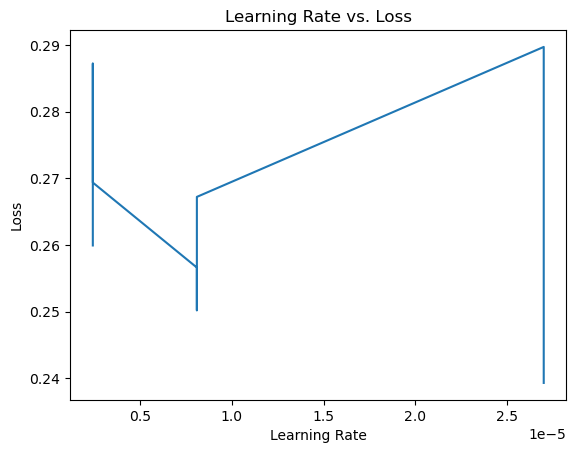

In [29]:
#train = True
checkpoint_dir = 'checkpoints'


training_result = Train_model()
model = training_result["net"]

# Visualize activations after training

defaultdict(<function <lambda> at 0x16e5dfd90>, {})


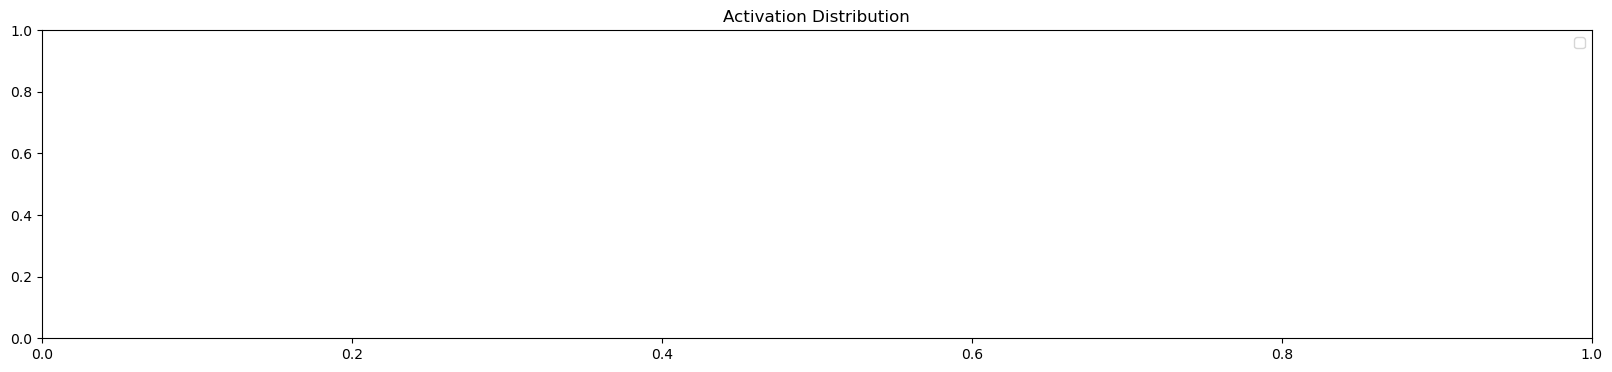

In [18]:
print(activation_metrics)
plt.figure(figsize=(20, 4))
legends = []
for name, t in activations:
    print(f'{name}: mean: {t.mean():+.2f}, std: {t.std():.2f}, saturated: {(t.abs() > 0.97).float().mean() * 100:.2f}%')
    # Compute the histogram using numpy
    t_np = t.detach().cpu().numpy()
    hy, hx = np.histogram(t_np, bins=50, density=True)
    
    # Plot the histogram
    plt.plot(hx[:-1], hy)
    legends.append(name)
    
    # hy, hx = torch.histogram(t, density=True)
    # plt.plot(hx[:-1].detach().cpu(), hy.detach().cpu())
    # legends.append(name)
plt.legend(legends)
plt.title('Activation Distribution')
plt.show()

In [ ]:
# Assuming 'activations' is a list of (name, tensor) tuples

plt.figure(figsize=(20, 4))
legends = []
for name, t in activations:
    # Calculate metrics
    zero_percentage = (t == 0).float().mean() * 100
    mean_value = t.mean().item()
    std_value = t.std().item()
    sparsity = (t != 0).float().mean() * 100
    variance = t.var().item()

    print(f'{name}: mean: {mean_value:+.2f}, std: {std_value:.2f}, zeros: {zero_percentage:.2f}%, sparsity: {sparsity:.2f}%, variance: {variance:.2f}')
    
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach().cpu(), hy.detach().cpu())
    legends.append(name)

plt.legend(legends[:3])
plt.title('Activation Distribution')
plt.show()

In [ ]:
# After training, aggregate and visualize activation metrics
plt.figure(figsize=(20, 4))
legends = []

for i, (name, data) in enumerate(activation_metrics.items()):
    all_tensors = torch.cat(data['tensors'], dim=0)
    
    # Calculate metrics
    zero_percentage = (all_tensors == 0).float().mean() * 100
    mean_value = all_tensors.mean().item()
    std_value = all_tensors.std().item()
    sparsity = (all_tensors != 0).float().mean() * 100
    variance = all_tensors.var().item()
    #saturated_percentage = (all_tensors.abs() > 0.97).float().mean() * 100

    print(f'Layer {i} ({name}): mean: {mean_value:+.2f}, std: {std_value:.2f}, zeros: {zero_percentage:.2f}%, sparsity: {sparsity:.2f}%, variance: {variance:.2f}')#, saturated: {saturated_percentage:.2f}%')
    
    hy, hx = torch.histogram(all_tensors, density=True)
    plt.plot(hx[:-1].detach().cpu(), hy.detach().cpu())
    legends.append(f'Layer {i} ({name})')

plt.legend(legends)
plt.title('Activation Distribution')
plt.show()

# viz gradient distributions

In [ ]:
# too long print of stats

#viz gradient distributions
#Visualize gradients after training
plt.figure(figsize=(20, 4))
legends = []
for name, grad in gradients:
    #print(f'{name}: mean: {grad.mean():+.2f}, std: {grad.std():.2e}')
    hy, hx = torch.histogram(grad, density=True)
    plt.plot(hx[:-1].detach().cpu(), hy.detach().cpu())
    legends.append(name)
plt.legend(legends)
plt.title('Gradient Distribution')
plt.show()

# Visualize gradients after training

In [ ]:

plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(net.parameters()):
    if p.grad is not None and p.ndim == 2:
        t = p.grad
        print(f'weight {tuple(p.shape)} | mean {t.mean():+.2f} | std {t.std():.2e} | grad:data ratio {t.std() / p.std():.2e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach().cpu(), hy.detach().cpu())
        legends.append(f'{i} ({tuple(p.shape)})')
plt.legend(legends)
plt.title('Weight Gradient Distribution')
plt.show()

In [ ]:
#visualize histogram of activations
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []
for i,layer in enumerate(net): #not excluding the last layer since there is no softmax
    if isinstance(layer, ReLU):
        t = layer.out
        print('layer %d (%10s): mean: %+.2f, std: %.2f, saturated: %.2f%%' %(i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribation')

In [ ]:
#visualize histogram of gradient
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters): 
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # those ratios should be ~1e-3, indicated on the plot with black         
plt.legend(legends);
plt.title('update to data raio distribation, LR setting')

# load from backup

In [ ]:
# def load_model_from_checkpoint():
#     checkpoint = torch.load('checkpoints/model_epoch_99.pt')

#     net = Network()
#     net.load_state_dict(checkpoint)
#     net.eval()

#     return net

In [ ]:

# def save_checkpoint(net, epoch, checkpoint_dir='checkpoints'):
#     os.makedirs(checkpoint_dir, exist_ok=True)
#     checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt')
#     torch.save(net.state_dict(), checkpoint_path)
    


In [ ]:
train = True
checkpoint_dir = 'checkpoints'

if train:
    training_result = Train_model()
    model = training_result["net"]
else:
    model = load_latest_checkpoint(checkpoint_dir)

In [ ]:
from IPython.display import Image

plt.plot(training_result[losses])
plt.show()

    